In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Add this magic command for inline plotting in notebooks
%matplotlib inline

from simulation.mean_cv_t_ac import find_tilda_parameters
from simulation.simulate_telegraph_model import simulate_one_telegraph_model_system
from stats.mean import calculate_mean
from stats.variance import calculate_variance
from stats.cv import calculate_cv
from stats.autocorrelation import (
    calculate_autocorrelation,
    calculate_ac_time_interp1d,
)


CSV_PATH = "/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/IY010_simulation_parameters.csv"


def load_high_error_cases(csv_path: str) -> tuple[float, float]:
    """Return (mu, t_ac) for a case with large CV relative error."""
    df = pd.read_csv(csv_path)
    mask = (
        df["success"].fillna(False)
        & (df["cv_target"] >= 3.0) # take cases with high CV targets
        & (df["ac_rel_error_pct"].fillna(0) > 20.0) # pick cases with ac high relative errors (since that's where most variability was observed)
    )

    cases = df.loc[mask, ["mu_target", "t_ac_target", "cv_target"]].drop_duplicates()
    if cases.empty:
        raise ValueError("No high-error cases found in parameter file")
    return cases

def simulate_case(mu: float,  cv: float, t_ac: float, 
                  time_factors: list[int],
                  size: int = 200,
                  dt: int = 1,
                  ) -> pd.DataFrame:
    """Simulate multiple sample sizes and CVs, returning relative CV errors.
    Parameters:
        mu: Mean expression level
        cv: Coefficient of variation
        t_ac: Autocorrelation time
        timepoint_factor: List of factors to multiply t_ac to get total simulated time
        size: Number of time series to simulate (default: 200)
        dt: Time step for simulation (default: 1)
    """

    results = []

    # get the parameters for the given mu, cv, t_ac
    rho, d, sigma_b, sigma_u = find_tilda_parameters(mu, t_ac, cv)
    params = [{"sigma_b": sigma_b, "sigma_u": sigma_u, "rho": rho, "d": d, "label": 0}]
    
    for factor in time_factors:
        # total simulated time = factor * t_ac (ensure minimally long runs)
        t_max = max(int(t_ac * factor), 50)  # keep a floor to avoid too-short series
        time_points = np.arange(0, t_max, dt)
        
        print(f"Simulating case: mu={mu}, cv={cv}, t_ac={t_ac}, timepoint scaling factor={factor}")
        df_results = simulate_one_telegraph_model_system(params, time_points, size=size)
        # drop the labels as we dont need them for analysis
        trajectories = df_results[df_results["label"] == 0].drop("label", axis=1).values
        # calculate the measured stats
        mean_obs = calculate_mean(trajectories, params, use_steady_state=True)
        var_obs = calculate_variance(trajectories, params, use_steady_state=True)
        cv_obs = calculate_cv(var_obs, mean_obs)
        ac = calculate_autocorrelation(df_results)
        ac_mean = ac["stress_ac"].mean(axis=0)
        lags = ac["stress_lags"]
        t_ac_obs = calculate_ac_time_interp1d(ac_mean, lags)
        
        # calculate the relative errors
        mean_rel_error = abs(mean_obs - mu) / mu
        cv_rel_error = abs(cv_obs - cv) / cv
        ac_rel_error = abs(t_ac_obs - t_ac) / t_ac

        results.append({
            "cv_target": cv, 
            "total_time": float(t_max),          # x-axis value
            "time_factor": int(factor),          # also useful to inspect
            'mean_rel_error_pct': mean_rel_error * 100,
            'cv_rel_error_pct': cv_rel_error * 100,
            'ac_rel_error_pct': ac_rel_error * 100
                        })
    return pd.DataFrame(results)

In [ ]:
cases = load_high_error_cases(CSV_PATH).head(5) # get the first 5 cases
# Sweep time-span factors (short → long)
time_factors = [2, 5, 10, 20, 50, 100, 150, 200]

all_results = []
# resimulate original cases
for _, row in cases.iterrows():
    mu, cv, t_ac = row["mu_target"], row["cv_target"], row["t_ac_target"]
    df_case = simulate_case(mu, cv, t_ac, time_factors = time_factors)
    # add the mu cv and t_ac to df_case
    df_case["mu cv t_ac"] = f"{mu:.3f}_{cv:.3f}_{t_ac:.3f}"

    # check if df_case is empty
    if df_case.empty:
        print(f"!!Warning!!: simulate_case returned empty DataFrame for mu={mu}, cv={cv}, t_ac={t_ac}")
        continue
    all_results.append(df_case)

if not all_results:
    raise ValueError("No valid simulation results obtained")
df = pd.concat(all_results, ignore_index=True)

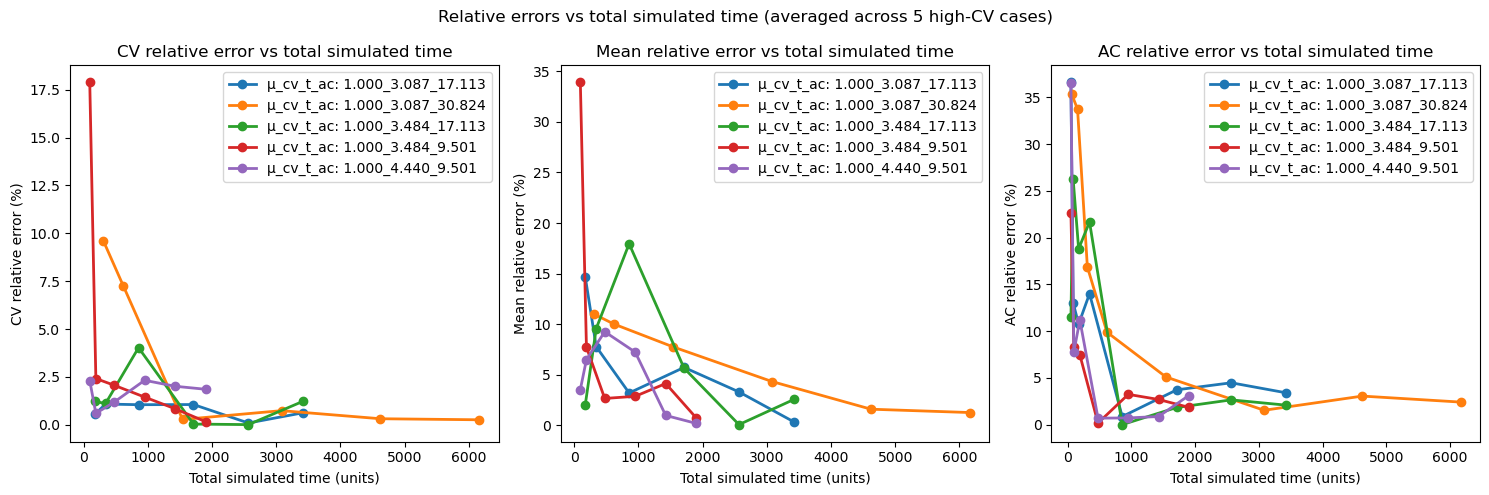

In [31]:
# Create subplots for the three metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot CV relative error
cv_pivot = df.pivot_table(index="total_time", columns="mu cv t_ac", values="cv_rel_error_pct", aggfunc='mean')
for col in cv_pivot.columns:
    series = cv_pivot[col].dropna()  # Remove NaN values
    axes[0].plot(series.index, series.values, marker="o", label=f"μ_cv_t_ac: {col}", linewidth=2)
axes[0].set_xlabel("Total simulated time (units)")
axes[0].set_ylabel("CV relative error (%)")
axes[0].set_title(f"CV relative error vs total simulated time")
axes[0].legend()

# Plot mean relative error
mean_pivot = df.pivot_table(index="total_time", columns="mu cv t_ac", values="mean_rel_error_pct", aggfunc='mean')
for col in mean_pivot.columns:
    series = mean_pivot[col].dropna()  # Remove NaN values
    axes[1].plot(series.index, series.values, marker="o", label=f"μ_cv_t_ac: {col}", linewidth=2)
axes[1].set_xlabel("Total simulated time (units)")
axes[1].set_ylabel("Mean relative error (%)")
axes[1].set_title(f"Mean relative error vs total simulated time")
axes[1].legend()

# Plot autocorrelation relative error
ac_pivot = df.pivot_table(index="total_time", columns="mu cv t_ac", values="ac_rel_error_pct", aggfunc='mean')
for col in ac_pivot.columns:
    series = ac_pivot[col].dropna()  # Remove NaN values
    axes[2].plot(series.index, series.values, marker="o", label=f"μ_cv_t_ac: {col}", linewidth=2)
axes[2].set_xlabel("Total simulated time (units)")
axes[2].set_ylabel("AC relative error (%)")
axes[2].set_title(f"AC relative error vs total simulated time")
axes[2].legend()

# Add overall title with parameters
fig.suptitle(f"Relative errors vs total simulated time (averaged across {len(cases)} high-CV cases)")

plt.tight_layout()
plt.show()
# Save the figure
# plt.savefig("high_cv_sample_timepoint_analysis.png")